## Prediction of COVID-19 using CXR Images

In [1]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torchvision.io import read_image
from torchvision.utils import save_image


In [2]:
# GLOBAL VARIABLE
DATA_PATH = './COVID-19_Radiography_Dataset'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
TRAIN_RATIO = 0.8
IMAGE_SIZE = 256
CHANNELS_IMG = 3
NUM_CLASSES = 1
LEARNING_RATE = 2e-4
L1_LAMBDA = 100
NUM_EPOCHS = 100
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_VGG = 'vgg.pth.tar'
BEST_CHECKPOINT_VGG = 'best_vgg.pth.tar'
CHECKPOINT_INCEPTION = 'inception.pth.tar'
BEST_CHECKPOINT_INCEPTION = 'best_inception.pth.tar'

### Data Collection and Preprocessing

- COVID-19 Radiography Database: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
- COVID-QU-Ex Database: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu

In [3]:
class COVID_Dataset(Dataset):
    def __init__(self, root_dir=DATA_PATH, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Normal', 'COVID'] # 0 = Normal, 1 = COVID
        self.images = []
        self.labels = []
        
        # load the images from the directories
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name, 'images')
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = read_image(self.images[index])
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# Making sure the custom dataset is working
dataset = COVID_Dataset(root_dir=DATA_PATH, transform=None)
len(dataset)

13808

Image shape: torch.Size([1, 299, 299])


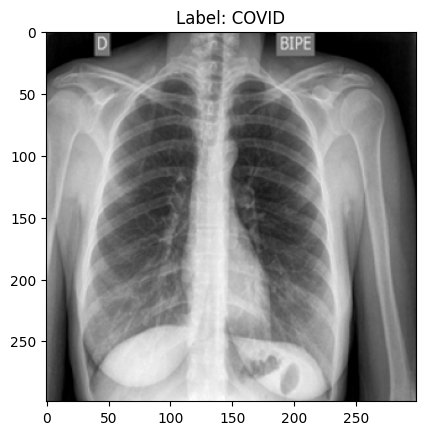

In [5]:
# Access an image and its label
image, label = dataset[12000]
print(f"Image shape: {image.shape}")

# Visualize the Image
plt.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title(f"Label: {dataset.classes[label]}")
plt.show()

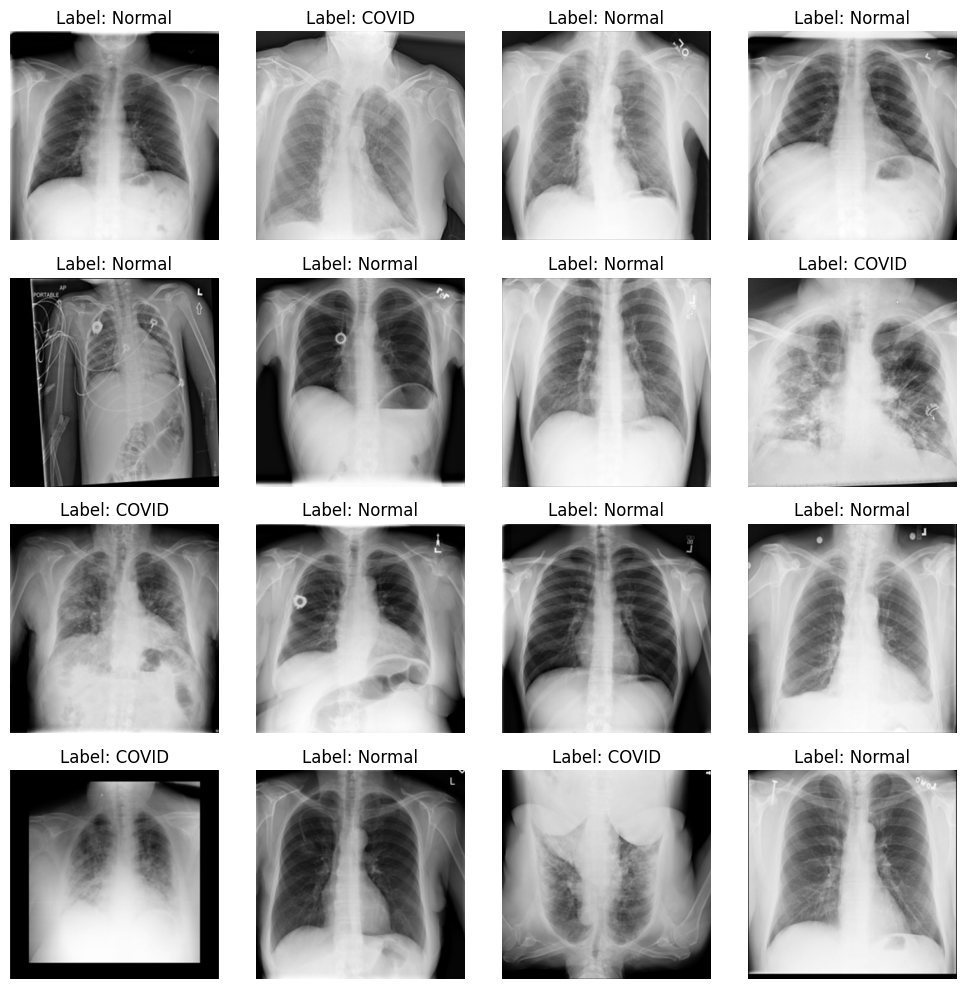

In [6]:
# Cerate a data loader
covid_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
images, labels = next(iter(covid_dataloader))   

# Visualize the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
    ax.set_title(f"Label: {dataset.classes[labels[i].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Split Data into Training and Validation Sets & Data Loaders

In [7]:
## DEFINE TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Create a new dataset with the transformations
dataset = COVID_Dataset(root_dir=DATA_PATH, transform=transform)

# Calculate the sizes of the training and testing datasets
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"Train Dataset Size: {len(train_dataset)} \nTest Dataset Size: {len(test_dataset)}")

# Create DataLoaders for the training and etsting datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train Dataset Size: 11046 
Test Dataset Size: 2762


### Models

In [8]:
# Load pretrained VGG 16 model
model = models.vgg16(pretrained=True)
print(model)

c:\Users\Army\Desktop\VSCode_Workspace\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Army\Desktop\VSCode_Workspace\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# Modifying the pretrained model
# Change the number of output nodes to match the number of classes
model.classifier[6] = nn.Linear(4096, 1)
model.to(DEVICE)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# determine the number of parameters
print(sum(x.reshape(-1).shape[0] for x in model.parameters()))

134264641


In [11]:
x = torch.rand((1, 3, 256, 256)).to(DEVICE)
y_pred = model(x)
print(y_pred)

tensor([[-0.1766]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [12]:
model.classifier[0].in_features

25088

#### Custom VGG-16 Model

In [13]:
class CustomVGG(nn.Module):
    def __init__(self, num_channels=3, num_classes=2):
        super(CustomVGG, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        
        # modify the first convolutional layer to accept a single-channel input
        vgg16.features[0] = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)
        
        # replace the original classifier part with a new classifier for binary classification
        num_features = vgg16.classifier[0].in_features
        vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes, bias=True),
        )
        
        self.model = vgg16
    
    def forward(self, x):
        # replicate the single channel to make it a 3 channel input
        x = x.repeat(1, 3, 1, 1)
        return self.model(x)

In [14]:
custom_vgg = CustomVGG(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
x = torch.rand((1, 1, 256, 256)).to(DEVICE)
y_pred = custom_vgg(x)
print(y_pred)

tensor([[0.0080]], device='cuda:0', grad_fn=<AddmmBackward0>)


#### InceptionResNet

In [15]:
inception_model = models.inception_v3(weights=models.Inception_V3_Weights).to(DEVICE)
print(sum(x.reshape(-1).shape[0] for x in inception_model.parameters()))
print(inception_model)

c:\Users\Army\Desktop\VSCode_Workspace\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


27161264
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [16]:
class CustomInceptionV3(nn.Module):
    def __init__(self, num_channels=3, num_classes=1):
        super(CustomInceptionV3, self).__init__()
        # Load the pretrained Inception v3 model
        inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights)
        
        # modify the first convolutional layer to accept a single-channel input
        inception_v3.Conv2d_1a_3x3 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=2)
        
        # replace the original classifier with a new classifier for binary classification
        num_features = inception_v3.fc.in_features
        inception_v3.fc = nn.Linear(num_features, num_classes)
        
        # set the model to only return the main output
        inception_v3.aux_logits = False
        
        self.model = inception_v3
        
    def forward(self, x):
        # replicate the single channel to make it a 3 channel input
        x = x.repeat(1, 3, 1, 1)
        # resize the input image to 299x299 which is required input size for inception v3 model
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        return self.model(x)

In [17]:
inception_v3 = CustomInceptionV3(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
inception_v3.eval()
x = torch.rand((1, 1, 256, 256)).to(DEVICE)
y_pred = inception_v3(x)
print(y_pred.shape)

torch.Size([1, 1])


### Train

In [18]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpiont...")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoing...")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # avoid optimizer having older checkpoint learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def save_matrices(file_loc, epochs, train_losses, train_accs, valid_losses, valid_accs):
     # save the training and validation losses and accuracy to a csv file
    import csv
    epochs_list = [i for i in range(epochs)]

    print("Saving the performance matrices...")
    with open(file_loc, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
        for i in range(epochs):
            writer.writerow([epochs_list[i], train_losses[i], train_accs[i], valid_losses[i], valid_accs[i]])


def load_matrices(file_loc):
    # load the training and validation losses and accuracy from a csv file
    import csv
    epochs = []
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    with open(file_loc, mode='r') as file:
        reader = csv.reader(file)
        next(reader) # skip the header
        for row in reader:
            epochs.append(int(row[0]))
            train_losses.append(float(row[1]))
            train_accs.append(float(row[2]))
            valid_losses.append(float(row[3]))
            valid_accs.append(float(row[4]))
    
    return epochs, train_losses, train_accs, valid_losses, valid_accs

In [19]:
def train(model, data_loader, optimizer, loss_fnc, scaler, epoch_num):
    # the main training loop
    loop = tqdm(data_loader, leave=True)
    model.train()
    losses = []
    accs = []
    loop.set_description(f"Epoch {epoch_num}")
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE).float()
        with torch.cuda.amp.autocast():        
            # forward pass
            y_pred = model(x).squeeze()
            loss = loss_fnc(y_pred, y)
            
            # backward pass
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # logging
            acc = ((y_pred > 0.5).float() == y).float().mean()
            loop.set_postfix(loss=loss.item(), acc=acc.item())
            losses.append(loss.item())
            accs.append(acc.item())
            
    return losses, accs

#### Train VGG16

In [20]:
# intialize the model
model = CustomVGG(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)

# intialize the optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# intialize the loss function; binary cross entropy loss
criterion = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross entropy loss; removes the sigmoid from the last layer
scaler = torch.cuda.amp.GradScaler()

# load the model checkpoint if it exists
if LOAD_MODEL:
    load_checkpoint(BEST_CHECKPOINT_VGG, model, optimizer, LEARNING_RATE)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_loss = float('inf')
print(f"Start Training on {DEVICE}...")
for epoch in range(NUM_EPOCHS):
    loss, acc = train(model, train_loader, optimizer, criterion, scaler, epoch)
    # compute the average loss for the epoch
    train_losses.append(sum(loss)/len(loss))
    train_accs.append(sum(acc)/len(acc))

    # evaluate the accuracy at the end of each epoch
    model.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE).float()
            y_pred = model(x).squeeze()
            loss = criterion(y_pred, y)
            acc = ((y_pred > 0.5).float() == y).float().mean()
            valid_loss.append(loss.item())
            valid_acc.append(acc.item())
    # compute the average validation loss and accuracy for this epoch
    valid_losses.append(sum(valid_loss)/len(valid_loss))
    valid_accs.append(sum(valid_acc)/len(valid_acc))
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]:.4f}")
    
    # save the best model checkpoint
    if valid_losses[-1] < best_loss:
        best_loss = valid_losses[-1]
        save_checkpoint(model, optimizer, filename=BEST_CHECKPOINT_VGG)
    # save the model checkpoint every 5 epochs
    if SAVE_MODEL and epoch % 5 == 0:
        save_checkpoint(model, optimizer, filename=CHECKPOINT_VGG)
        

Start Training on cuda...


Epoch 0: 100%|██████████| 346/346 [02:00<00:00,  2.87it/s, acc=1, loss=0.258]     


Epoch [0/100] Loss: 0.3685, Acc: 0.8330 | Val Loss: 0.2461, Val Acc: 0.9011
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 1: 100%|██████████| 346/346 [02:15<00:00,  2.55it/s, acc=0.833, loss=0.442] 


Epoch [1/100] Loss: 0.1880, Acc: 0.9189 | Val Loss: 0.1567, Val Acc: 0.9497
=> Saving checkpiont...


Epoch 2: 100%|██████████| 346/346 [02:17<00:00,  2.52it/s, acc=1, loss=0.0423]    


Epoch [2/100] Loss: 0.1253, Acc: 0.9506 | Val Loss: 0.5370, Val Acc: 0.9456
=> Saving checkpiont...


Epoch 3: 100%|██████████| 346/346 [02:19<00:00,  2.47it/s, acc=1, loss=0.272]     


Epoch [3/100] Loss: 0.1149, Acc: 0.9582 | Val Loss: 0.1401, Val Acc: 0.9497
=> Saving checkpiont...


Epoch 4: 100%|██████████| 346/346 [02:19<00:00,  2.49it/s, acc=1, loss=0.0217]    


Epoch [4/100] Loss: 0.0914, Acc: 0.9632 | Val Loss: 0.0960, Val Acc: 0.9658
=> Saving checkpiont...


Epoch 5: 100%|██████████| 346/346 [02:20<00:00,  2.46it/s, acc=1, loss=0.000144]  


Epoch [5/100] Loss: 0.0649, Acc: 0.9759 | Val Loss: 0.1115, Val Acc: 0.9511
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 6: 100%|██████████| 346/346 [02:17<00:00,  2.51it/s, acc=1, loss=0.000175]  


Epoch [6/100] Loss: 0.0571, Acc: 0.9788 | Val Loss: 0.0799, Val Acc: 0.9763
=> Saving checkpiont...


Epoch 7: 100%|██████████| 346/346 [02:18<00:00,  2.50it/s, acc=1, loss=0.000168]  


Epoch [7/100] Loss: 0.0438, Acc: 0.9840 | Val Loss: 0.1093, Val Acc: 0.9659
=> Saving checkpiont...


Epoch 8: 100%|██████████| 346/346 [02:14<00:00,  2.58it/s, acc=0.833, loss=0.532] 


Epoch [8/100] Loss: 0.0409, Acc: 0.9843 | Val Loss: 0.0652, Val Acc: 0.9802
=> Saving checkpiont...


Epoch 9: 100%|██████████| 346/346 [02:10<00:00,  2.65it/s, acc=1, loss=9.63e-5]   


Epoch [9/100] Loss: 0.0643, Acc: 0.9767 | Val Loss: 0.0775, Val Acc: 0.9688
=> Saving checkpiont...


Epoch 10: 100%|██████████| 346/346 [02:08<00:00,  2.69it/s, acc=1, loss=1.99e-7]   


Epoch [10/100] Loss: 0.0269, Acc: 0.9899 | Val Loss: 0.0625, Val Acc: 0.9766
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 11: 100%|██████████| 346/346 [02:07<00:00,  2.70it/s, acc=1, loss=8.07e-5]   


Epoch [11/100] Loss: 0.0307, Acc: 0.9893 | Val Loss: 0.0749, Val Acc: 0.9751
=> Saving checkpiont...


Epoch 12: 100%|██████████| 346/346 [02:17<00:00,  2.52it/s, acc=1, loss=0.0352]    


Epoch [12/100] Loss: 0.0341, Acc: 0.9885 | Val Loss: 0.1510, Val Acc: 0.9636
=> Saving checkpiont...


Epoch 13: 100%|██████████| 346/346 [02:28<00:00,  2.33it/s, acc=1, loss=5.9e-6]    


Epoch [13/100] Loss: 0.0327, Acc: 0.9886 | Val Loss: 0.1546, Val Acc: 0.9659
=> Saving checkpiont...


Epoch 14: 100%|██████████| 346/346 [02:15<00:00,  2.56it/s, acc=1, loss=0.00233]   


Epoch [14/100] Loss: 0.0242, Acc: 0.9910 | Val Loss: 0.0878, Val Acc: 0.9733
=> Saving checkpiont...


Epoch 15: 100%|██████████| 346/346 [02:12<00:00,  2.62it/s, acc=1, loss=0.000881]  


Epoch [15/100] Loss: 0.0924, Acc: 0.9810 | Val Loss: 0.0915, Val Acc: 0.9788
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 16: 100%|██████████| 346/346 [02:08<00:00,  2.68it/s, acc=1, loss=6.97e-5]   


Epoch [16/100] Loss: 0.0319, Acc: 0.9891 | Val Loss: 0.0931, Val Acc: 0.9756
=> Saving checkpiont...


Epoch 17: 100%|██████████| 346/346 [02:15<00:00,  2.55it/s, acc=1, loss=4.27e-5]   


Epoch [17/100] Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0786, Val Acc: 0.9723
=> Saving checkpiont...


Epoch 18: 100%|██████████| 346/346 [02:14<00:00,  2.57it/s, acc=1, loss=1.39e-7]   


Epoch [18/100] Loss: 0.0282, Acc: 0.9917 | Val Loss: 0.1052, Val Acc: 0.9767
=> Saving checkpiont...


Epoch 19: 100%|██████████| 346/346 [02:20<00:00,  2.46it/s, acc=1, loss=0.00164]   


Epoch [19/100] Loss: 0.0195, Acc: 0.9945 | Val Loss: 0.0715, Val Acc: 0.9781
=> Saving checkpiont...


Epoch 20: 100%|██████████| 346/346 [02:24<00:00,  2.39it/s, acc=1, loss=1.79e-7]   


Epoch [20/100] Loss: 0.0277, Acc: 0.9916 | Val Loss: 0.1653, Val Acc: 0.9634
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 21: 100%|██████████| 346/346 [02:16<00:00,  2.54it/s, acc=1, loss=0]         


Epoch [21/100] Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.0675, Val Acc: 0.9784
=> Saving checkpiont...


Epoch 22: 100%|██████████| 346/346 [02:23<00:00,  2.40it/s, acc=1, loss=0]         


Epoch [22/100] Loss: 0.0193, Acc: 0.9931 | Val Loss: 0.1035, Val Acc: 0.9810
=> Saving checkpiont...


Epoch 23: 100%|██████████| 346/346 [02:20<00:00,  2.46it/s, acc=1, loss=2.58e-7]   


Epoch [23/100] Loss: 0.0225, Acc: 0.9939 | Val Loss: 0.0823, Val Acc: 0.9820
=> Saving checkpiont...


Epoch 24: 100%|██████████| 346/346 [02:22<00:00,  2.43it/s, acc=1, loss=3.61e-5]   


Epoch [24/100] Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1444, Val Acc: 0.9730
=> Saving checkpiont...


Epoch 25: 100%|██████████| 346/346 [02:20<00:00,  2.46it/s, acc=1, loss=0]         


Epoch [25/100] Loss: 0.0234, Acc: 0.9932 | Val Loss: 0.0635, Val Acc: 0.9860
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 26: 100%|██████████| 346/346 [02:17<00:00,  2.52it/s, acc=1, loss=0.000249]  


Epoch [26/100] Loss: 0.0096, Acc: 0.9975 | Val Loss: 0.1059, Val Acc: 0.9820
=> Saving checkpiont...


Epoch 27: 100%|██████████| 346/346 [02:12<00:00,  2.62it/s, acc=1, loss=0.0182]    


Epoch [27/100] Loss: 0.0248, Acc: 0.9932 | Val Loss: 0.3404, Val Acc: 0.9612
=> Saving checkpiont...


Epoch 28: 100%|██████████| 346/346 [02:10<00:00,  2.66it/s, acc=1, loss=0.00194]   


Epoch [28/100] Loss: 0.0428, Acc: 0.9893 | Val Loss: 0.0976, Val Acc: 0.9752
=> Saving checkpiont...


Epoch 29: 100%|██████████| 346/346 [02:17<00:00,  2.52it/s, acc=1, loss=0.0519]    


Epoch [29/100] Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.0703, Val Acc: 0.9798
=> Saving checkpiont...


Epoch 30: 100%|██████████| 346/346 [02:16<00:00,  2.54it/s, acc=1, loss=0.0332]    


Epoch [30/100] Loss: 0.0126, Acc: 0.9968 | Val Loss: 0.0575, Val Acc: 0.9834
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 31: 100%|██████████| 346/346 [02:14<00:00,  2.56it/s, acc=1, loss=0.00729]   


Epoch [31/100] Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.0591, Val Acc: 0.9846
=> Saving checkpiont...


Epoch 32: 100%|██████████| 346/346 [02:14<00:00,  2.57it/s, acc=1, loss=0]         


Epoch [32/100] Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0604, Val Acc: 0.9871
=> Saving checkpiont...


Epoch 33: 100%|██████████| 346/346 [02:07<00:00,  2.71it/s, acc=1, loss=1.99e-8]   


Epoch [33/100] Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.0648, Val Acc: 0.9856
=> Saving checkpiont...


Epoch 34: 100%|██████████| 346/346 [02:09<00:00,  2.67it/s, acc=1, loss=0.000436]  


Epoch [34/100] Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1240, Val Acc: 0.9816
=> Saving checkpiont...


Epoch 35: 100%|██████████| 346/346 [02:06<00:00,  2.74it/s, acc=1, loss=0]         


Epoch [35/100] Loss: 0.0270, Acc: 0.9920 | Val Loss: 0.0916, Val Acc: 0.9853
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 36: 100%|██████████| 346/346 [02:09<00:00,  2.67it/s, acc=1, loss=0.000105]  


Epoch [36/100] Loss: 0.0179, Acc: 0.9954 | Val Loss: 0.1084, Val Acc: 0.9781
=> Saving checkpiont...


Epoch 37: 100%|██████████| 346/346 [02:09<00:00,  2.66it/s, acc=1, loss=0]         


Epoch [37/100] Loss: 0.0153, Acc: 0.9958 | Val Loss: 0.1095, Val Acc: 0.9756
=> Saving checkpiont...


Epoch 38: 100%|██████████| 346/346 [02:10<00:00,  2.65it/s, acc=1, loss=0.00015]   


Epoch [38/100] Loss: 0.0335, Acc: 0.9916 | Val Loss: 0.0820, Val Acc: 0.9823
=> Saving checkpiont...


Epoch 39: 100%|██████████| 346/346 [02:09<00:00,  2.68it/s, acc=1, loss=6.65e-5]   


Epoch [39/100] Loss: 0.0272, Acc: 0.9944 | Val Loss: 0.0716, Val Acc: 0.9838
=> Saving checkpiont...


Epoch 40: 100%|██████████| 346/346 [02:07<00:00,  2.72it/s, acc=1, loss=4.73e-5]   


Epoch [40/100] Loss: 0.0176, Acc: 0.9949 | Val Loss: 0.0958, Val Acc: 0.9777
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 41: 100%|██████████| 346/346 [02:09<00:00,  2.68it/s, acc=0.833, loss=0.93]  


Epoch [41/100] Loss: 0.0301, Acc: 0.9946 | Val Loss: 0.1318, Val Acc: 0.9694
=> Saving checkpiont...


Epoch 42: 100%|██████████| 346/346 [02:11<00:00,  2.64it/s, acc=1, loss=9.74e-6]   


Epoch [42/100] Loss: 0.0197, Acc: 0.9942 | Val Loss: 0.0747, Val Acc: 0.9838
=> Saving checkpiont...


Epoch 43: 100%|██████████| 346/346 [02:11<00:00,  2.63it/s, acc=1, loss=0]         


Epoch [43/100] Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1675, Val Acc: 0.9777
=> Saving checkpiont...


Epoch 44: 100%|██████████| 346/346 [02:11<00:00,  2.64it/s, acc=1, loss=0.00401]   


Epoch [44/100] Loss: 0.0170, Acc: 0.9963 | Val Loss: 0.1842, Val Acc: 0.9605
=> Saving checkpiont...


Epoch 45: 100%|██████████| 346/346 [02:10<00:00,  2.64it/s, acc=1, loss=0.000866]  


Epoch [45/100] Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1102, Val Acc: 0.9792
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 46: 100%|██████████| 346/346 [02:10<00:00,  2.65it/s, acc=1, loss=0.000692]  


Epoch [46/100] Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.0513, Val Acc: 0.9820
=> Saving checkpiont...


Epoch 47: 100%|██████████| 346/346 [02:11<00:00,  2.64it/s, acc=1, loss=3.97e-8]   


Epoch [47/100] Loss: 0.0113, Acc: 0.9974 | Val Loss: 0.1176, Val Acc: 0.9842
=> Saving checkpiont...


Epoch 48: 100%|██████████| 346/346 [02:11<00:00,  2.64it/s, acc=1, loss=0]         


Epoch [48/100] Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.0934, Val Acc: 0.9878
=> Saving checkpiont...


Epoch 49: 100%|██████████| 346/346 [02:08<00:00,  2.68it/s, acc=1, loss=0.0421]    


Epoch [49/100] Loss: 0.0165, Acc: 0.9964 | Val Loss: 0.0882, Val Acc: 0.9727
=> Saving checkpiont...


Epoch 50: 100%|██████████| 346/346 [02:10<00:00,  2.66it/s, acc=1, loss=2.78e-7]   


Epoch [50/100] Loss: 0.0203, Acc: 0.9947 | Val Loss: 0.0431, Val Acc: 0.9838
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 51: 100%|██████████| 346/346 [02:06<00:00,  2.73it/s, acc=1, loss=1.12e-5]   


Epoch [51/100] Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.0851, Val Acc: 0.9864
=> Saving checkpiont...


Epoch 52: 100%|██████████| 346/346 [02:06<00:00,  2.74it/s, acc=1, loss=0.00364]   


Epoch [52/100] Loss: 0.0096, Acc: 0.9977 | Val Loss: 0.2705, Val Acc: 0.9759
=> Saving checkpiont...


Epoch 53: 100%|██████████| 346/346 [02:06<00:00,  2.74it/s, acc=1, loss=0.037]     


Epoch [53/100] Loss: 0.0159, Acc: 0.9957 | Val Loss: 0.2458, Val Acc: 0.9759
=> Saving checkpiont...


Epoch 54: 100%|██████████| 346/346 [02:11<00:00,  2.63it/s, acc=1, loss=6.79e-5]   


Epoch [54/100] Loss: 0.0287, Acc: 0.9938 | Val Loss: 0.0697, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 55: 100%|██████████| 346/346 [02:14<00:00,  2.56it/s, acc=1, loss=0.00811]   


Epoch [55/100] Loss: 0.0465, Acc: 0.9912 | Val Loss: 0.1138, Val Acc: 0.9705
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 56: 100%|██████████| 346/346 [02:15<00:00,  2.55it/s, acc=1, loss=7.95e-8]   


Epoch [56/100] Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0845, Val Acc: 0.9856
=> Saving checkpiont...


Epoch 57: 100%|██████████| 346/346 [02:28<00:00,  2.34it/s, acc=1, loss=0.000866]  


Epoch [57/100] Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.2119, Val Acc: 0.9810
=> Saving checkpiont...


Epoch 58: 100%|██████████| 346/346 [02:38<00:00,  2.18it/s, acc=1, loss=0.0834]    


Epoch [58/100] Loss: 0.0441, Acc: 0.9901 | Val Loss: 0.1171, Val Acc: 0.9770
=> Saving checkpiont...


Epoch 59: 100%|██████████| 346/346 [02:21<00:00,  2.44it/s, acc=1, loss=0]         


Epoch [59/100] Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1772, Val Acc: 0.9842
=> Saving checkpiont...


Epoch 60: 100%|██████████| 346/346 [01:37<00:00,  3.56it/s, acc=1, loss=0]       


Epoch [60/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1963, Val Acc: 0.9856
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 61: 100%|██████████| 346/346 [01:37<00:00,  3.55it/s, acc=1, loss=0]      


Epoch [61/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2122, Val Acc: 0.9856
=> Saving checkpiont...


Epoch 62: 100%|██████████| 346/346 [01:34<00:00,  3.66it/s, acc=1, loss=0]       


Epoch [62/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2311, Val Acc: 0.9849
=> Saving checkpiont...


Epoch 63: 100%|██████████| 346/346 [01:34<00:00,  3.64it/s, acc=1, loss=0]      


Epoch [63/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2398, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 64: 100%|██████████| 346/346 [01:54<00:00,  3.01it/s, acc=1, loss=0]      


Epoch [64/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2485, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 65: 100%|██████████| 346/346 [01:46<00:00,  3.25it/s, acc=1, loss=0]      


Epoch [65/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2508, Val Acc: 0.9853
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 66: 100%|██████████| 346/346 [01:34<00:00,  3.66it/s, acc=1, loss=3.1e-6] 


Epoch [66/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2486, Val Acc: 0.9860
=> Saving checkpiont...


Epoch 67: 100%|██████████| 346/346 [01:36<00:00,  3.58it/s, acc=1, loss=0]       


Epoch [67/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2067, Val Acc: 0.9846
=> Saving checkpiont...


Epoch 68: 100%|██████████| 346/346 [01:37<00:00,  3.54it/s, acc=1, loss=0]      


Epoch [68/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2251, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 69: 100%|██████████| 346/346 [01:37<00:00,  3.56it/s, acc=1, loss=0]      


Epoch [69/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2368, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 70: 100%|██████████| 346/346 [01:34<00:00,  3.64it/s, acc=1, loss=0]      


Epoch [70/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2423, Val Acc: 0.9853
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 71: 100%|██████████| 346/346 [01:38<00:00,  3.51it/s, acc=1, loss=0]      


Epoch [71/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2451, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 72: 100%|██████████| 346/346 [01:36<00:00,  3.59it/s, acc=1, loss=0]      


Epoch [72/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2508, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 73: 100%|██████████| 346/346 [01:38<00:00,  3.51it/s, acc=1, loss=0]      


Epoch [73/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2536, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 74: 100%|██████████| 346/346 [01:39<00:00,  3.47it/s, acc=1, loss=0]      


Epoch [74/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2604, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 75: 100%|██████████| 346/346 [01:35<00:00,  3.64it/s, acc=1, loss=0]      


Epoch [75/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2661, Val Acc: 0.9853
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 76: 100%|██████████| 346/346 [01:34<00:00,  3.66it/s, acc=1, loss=0]      


Epoch [76/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2745, Val Acc: 0.9846
=> Saving checkpiont...


Epoch 77: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0]      


Epoch [77/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2825, Val Acc: 0.9846
=> Saving checkpiont...


Epoch 78: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [78/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3078, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 79: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [79/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3093, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 80: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [80/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3168, Val Acc: 0.9853
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 81: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0]      


Epoch [81/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3234, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 82: 100%|██████████| 346/346 [01:31<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [82/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3251, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 83: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [83/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3272, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 84: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [84/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3372, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 85: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [85/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3400, Val Acc: 0.9853
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 86: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0]      


Epoch [86/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3618, Val Acc: 0.9856
=> Saving checkpiont...


Epoch 87: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [87/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3565, Val Acc: 0.9856
=> Saving checkpiont...


Epoch 88: 100%|██████████| 346/346 [01:31<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [88/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3472, Val Acc: 0.9849
=> Saving checkpiont...


Epoch 89: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0]      


Epoch [89/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3534, Val Acc: 0.9849
=> Saving checkpiont...


Epoch 90: 100%|██████████| 346/346 [01:31<00:00,  3.76it/s, acc=1, loss=0]      


Epoch [90/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.3590, Val Acc: 0.9849
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 91: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0.123]     


Epoch [91/100] Loss: 0.0760, Acc: 0.9769 | Val Loss: 0.1929, Val Acc: 0.9310
=> Saving checkpiont...


Epoch 92: 100%|██████████| 346/346 [01:31<00:00,  3.76it/s, acc=1, loss=0.0324]    


Epoch [92/100] Loss: 0.0937, Acc: 0.9710 | Val Loss: 0.0961, Val Acc: 0.9806
=> Saving checkpiont...


Epoch 93: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=5.09e-5]   


Epoch [93/100] Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.0839, Val Acc: 0.9816
=> Saving checkpiont...


Epoch 94: 100%|██████████| 346/346 [01:31<00:00,  3.76it/s, acc=1, loss=1.45e-5]   


Epoch [94/100] Loss: 0.0198, Acc: 0.9962 | Val Loss: 0.0811, Val Acc: 0.9759
=> Saving checkpiont...


Epoch 95: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=1.75e-6]   


Epoch [95/100] Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.0760, Val Acc: 0.9871
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 96: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0.000104]  


Epoch [96/100] Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0793, Val Acc: 0.9838
=> Saving checkpiont...


Epoch 97: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0.000664]  


Epoch [97/100] Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0454, Val Acc: 0.9853
=> Saving checkpiont...


Epoch 98: 100%|██████████| 346/346 [01:32<00:00,  3.76it/s, acc=1, loss=0]         


Epoch [98/100] Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0958, Val Acc: 0.9838
=> Saving checkpiont...


Epoch 99: 100%|██████████| 346/346 [01:32<00:00,  3.75it/s, acc=1, loss=0]         


Epoch [99/100] Loss: 0.0238, Acc: 0.9937 | Val Loss: 0.1065, Val Acc: 0.9784
=> Saving checkpiont...


In [21]:
# Save the performance matrices of the VGG 16 model after fine-tuning
save_matrices('vgg16_performance.csv', NUM_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

Saving the performance matrices...


#### Train InceptionV3

In [22]:
# intialize the model
model_inception = CustomInceptionV3(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)

# intialize the optimizers
optimizer = torch.optim.Adam(model_inception.parameters(), lr=LEARNING_RATE)

# intialize the loss function; binary cross entropy loss
criterion = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross entropy loss; removes the sigmoid from the last layer
scaler = torch.cuda.amp.GradScaler()

# load the model checkpoint if it exists
if LOAD_MODEL:
    load_checkpoint(BEST_CHECKPOINT_INCEPTION, model_inception, optimizer, LEARNING_RATE)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_loss = float('inf')
print(f"Start Training on {DEVICE}...")
for epoch in range(NUM_EPOCHS):
    loss, acc = train(model_inception, train_loader, optimizer, criterion, scaler, epoch)
    # compute the average loss for the epoch
    train_losses.append(sum(loss)/len(loss))
    train_accs.append(sum(acc)/len(acc))

    # evaluate the accuracy at the end of each epoch
    model_inception.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE).float()
            y_pred = model_inception(x).squeeze()
            loss = criterion(y_pred, y)
            acc = ((y_pred > 0.5).float() == y).float().mean()
            valid_loss.append(loss.item())
            valid_acc.append(acc.item())
    # compute the average validation loss and accuracy for this epoch
    valid_losses.append(sum(valid_loss)/len(valid_loss))
    valid_accs.append(sum(valid_acc)/len(valid_acc))
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]:.4f}")
    
    # save the best model checkpoint
    if valid_losses[-1] < best_loss:
        best_loss = valid_losses[-1]
        save_checkpoint(model_inception, optimizer, filename=BEST_CHECKPOINT_INCEPTION)
    # save the model checkpoint every 5 epochs
    if SAVE_MODEL and epoch % 5 == 0:
        save_checkpoint(model_inception, optimizer, filename=CHECKPOINT_INCEPTION)
        
        
# Save the performance matrices of the INCEPTION model after fine-tuning
save_matrices('inception_performance.csv', NUM_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

Start Training on cuda...


Epoch 0: 100%|██████████| 346/346 [01:02<00:00,  5.55it/s, acc=1, loss=0.00185]   


Epoch [0/100] Loss: 0.1039, Acc: 0.9629 | Val Loss: 0.0533, Val Acc: 0.9874
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 1: 100%|██████████| 346/346 [01:01<00:00,  5.64it/s, acc=1, loss=0.00523]   


Epoch [1/100] Loss: 0.0367, Acc: 0.9885 | Val Loss: 0.0846, Val Acc: 0.9695


Epoch 2: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=0.833, loss=0.116] 


Epoch [2/100] Loss: 0.0250, Acc: 0.9908 | Val Loss: 0.0290, Val Acc: 0.9914
=> Saving checkpiont...


Epoch 3: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=0.000141]  


Epoch [3/100] Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0227, Val Acc: 0.9921
=> Saving checkpiont...


Epoch 4: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.000963]  


Epoch [4/100] Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0416, Val Acc: 0.9892


Epoch 5: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=0.0233]    


Epoch [5/100] Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0196, Val Acc: 0.9935
=> Saving checkpiont...
=> Saving checkpiont...


Epoch 6: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=4.41e-5]   


Epoch [6/100] Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.0211, Val Acc: 0.9950


Epoch 7: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.0411]    


Epoch [7/100] Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.0331, Val Acc: 0.9928


Epoch 8: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.0003]    


Epoch [8/100] Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0144, Val Acc: 0.9964
=> Saving checkpiont...


Epoch 9: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.000818]  


Epoch [9/100] Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0291, Val Acc: 0.9910


Epoch 10: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=0.833, loss=0.143] 


Epoch [10/100] Loss: 0.0126, Acc: 0.9952 | Val Loss: 0.0578, Val Acc: 0.9842
=> Saving checkpiont...


Epoch 11: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=8.72e-5]   


Epoch [11/100] Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.0216, Val Acc: 0.9909


Epoch 12: 100%|██████████| 346/346 [01:22<00:00,  4.21it/s, acc=1, loss=4.43e-6]   


Epoch [12/100] Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0324, Val Acc: 0.9917


Epoch 13: 100%|██████████| 346/346 [01:13<00:00,  4.68it/s, acc=1, loss=5.93e-5]   


Epoch [13/100] Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0138, Val Acc: 0.9950
=> Saving checkpiont...


Epoch 14: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=9.79e-5]   


Epoch [14/100] Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0571, Val Acc: 0.9813


Epoch 15: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=0.00402]   


Epoch [15/100] Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0261, Val Acc: 0.9935
=> Saving checkpiont...


Epoch 16: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=7.13e-5] 


Epoch [16/100] Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0193, Val Acc: 0.9946


Epoch 17: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=9.07e-5]   


Epoch [17/100] Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0421, Val Acc: 0.9896


Epoch 18: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=5.56e-7]   


Epoch [18/100] Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0226, Val Acc: 0.9943


Epoch 19: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=2.14e-5]   


Epoch [19/100] Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0260, Val Acc: 0.9932


Epoch 20: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.149]     


Epoch [20/100] Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0169, Val Acc: 0.9943
=> Saving checkpiont...


Epoch 21: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=3.31e-5]   


Epoch [21/100] Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0231, Val Acc: 0.9928


Epoch 22: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=0.667, loss=0.976] 


Epoch [22/100] Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0448, Val Acc: 0.9885


Epoch 23: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=1.79e-7]   


Epoch [23/100] Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0294, Val Acc: 0.9921


Epoch 24: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=2.44e-6] 


Epoch [24/100] Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0151, Val Acc: 0.9960


Epoch 25: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=1.59e-7] 


Epoch [25/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0170, Val Acc: 0.9960
=> Saving checkpiont...


Epoch 26: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=2.56e-5] 


Epoch [26/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0176, Val Acc: 0.9957


Epoch 27: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=6.52e-6] 


Epoch [27/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0174, Val Acc: 0.9960


Epoch 28: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=1.19e-6] 


Epoch [28/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0156, Val Acc: 0.9964


Epoch 29: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=0.833, loss=0.486]


Epoch [29/100] Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0614, Val Acc: 0.9849


Epoch 30: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.0344]    


Epoch [30/100] Loss: 0.0376, Acc: 0.9867 | Val Loss: 0.0297, Val Acc: 0.9914
=> Saving checkpiont...


Epoch 31: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=2.55e-5]   


Epoch [31/100] Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0194, Val Acc: 0.9928


Epoch 32: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=0.833, loss=1.34]  


Epoch [32/100] Loss: 0.0105, Acc: 0.9975 | Val Loss: 0.0214, Val Acc: 0.9921


Epoch 33: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=0.00142]   


Epoch [33/100] Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0186, Val Acc: 0.9953


Epoch 34: 100%|██████████| 346/346 [01:02<00:00,  5.55it/s, acc=1, loss=2.87e-5]   


Epoch [34/100] Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0200, Val Acc: 0.9953


Epoch 35: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=8.68e-6]   


Epoch [35/100] Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0233, Val Acc: 0.9939
=> Saving checkpiont...


Epoch 36: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=0]         


Epoch [36/100] Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0139, Val Acc: 0.9968


Epoch 37: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=0.000312]


Epoch [37/100] Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0155, Val Acc: 0.9960


Epoch 38: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=5.96e-8] 


Epoch [38/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0107, Val Acc: 0.9975
=> Saving checkpiont...


Epoch 39: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=1.99e-8] 


Epoch [39/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0103, Val Acc: 0.9971
=> Saving checkpiont...


Epoch 40: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=2.58e-7] 


Epoch [40/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0104, Val Acc: 0.9975
=> Saving checkpiont...


Epoch 41: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=1.79e-7] 


Epoch [41/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0120, Val Acc: 0.9975


Epoch 42: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=0.00253] 


Epoch [42/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0106, Val Acc: 0.9971


Epoch 43: 100%|██████████| 346/346 [01:02<00:00,  5.56it/s, acc=1, loss=1.99e-8] 


Epoch [43/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0109, Val Acc: 0.9968


Epoch 44: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=2.56e-6]   


Epoch [44/100] Loss: 0.0215, Acc: 0.9933 | Val Loss: 0.1206, Val Acc: 0.9648


Epoch 45: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.0279]    


Epoch [45/100] Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0211, Val Acc: 0.9935
=> Saving checkpiont...


Epoch 46: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=0.0209]   


Epoch [46/100] Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0218, Val Acc: 0.9953


Epoch 47: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=0.000324]  


Epoch [47/100] Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0327, Val Acc: 0.9914


Epoch 48: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=4.17e-7]   


Epoch [48/100] Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0256, Val Acc: 0.9950


Epoch 49: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=6.08e-6]   


Epoch [49/100] Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.0218, Val Acc: 0.9925


Epoch 50: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=1.35e-6]   


Epoch [50/100] Loss: 0.0031, Acc: 0.9986 | Val Loss: 0.0239, Val Acc: 0.9935
=> Saving checkpiont...


Epoch 51: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=7.87e-6]   


Epoch [51/100] Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0320, Val Acc: 0.9914


Epoch 52: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=1.85e-6]   


Epoch [52/100] Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0147, Val Acc: 0.9957


Epoch 53: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=3.97e-8] 


Epoch [53/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0134, Val Acc: 0.9960


Epoch 54: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=2.8e-6]    


Epoch [54/100] Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0119, Val Acc: 0.9968


Epoch 55: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=6.83e-6]   


Epoch [55/100] Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0141, Val Acc: 0.9964
=> Saving checkpiont...


Epoch 56: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.00998]   


Epoch [56/100] Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0461, Val Acc: 0.9892


Epoch 57: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=0.00442]   


Epoch [57/100] Loss: 0.0073, Acc: 0.9972 | Val Loss: 0.0221, Val Acc: 0.9914


Epoch 58: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=0.101]     


Epoch [58/100] Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.0170, Val Acc: 0.9953


Epoch 59: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=5.73e-5] 


Epoch [59/100] Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0125, Val Acc: 0.9964


Epoch 60: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=0.00141] 


Epoch [60/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0160, Val Acc: 0.9964
=> Saving checkpiont...


Epoch 61: 100%|██████████| 346/346 [01:02<00:00,  5.58it/s, acc=1, loss=6.16e-7] 


Epoch [61/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0171, Val Acc: 0.9964


Epoch 62: 100%|██████████| 346/346 [01:02<00:00,  5.58it/s, acc=1, loss=9.18e-6] 


Epoch [62/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0153, Val Acc: 0.9968


Epoch 63: 100%|██████████| 346/346 [01:02<00:00,  5.58it/s, acc=1, loss=0]       


Epoch [63/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0141, Val Acc: 0.9971


Epoch 64: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=0.833, loss=0.212]


Epoch [64/100] Loss: 0.0006, Acc: 0.9995 | Val Loss: 0.0135, Val Acc: 0.9971


Epoch 65: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=6.6e-5]    


Epoch [65/100] Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0790, Val Acc: 0.9828
=> Saving checkpiont...


Epoch 66: 100%|██████████| 346/346 [01:01<00:00,  5.62it/s, acc=1, loss=6.4e-6]    


Epoch [66/100] Loss: 0.0038, Acc: 0.9983 | Val Loss: 0.0214, Val Acc: 0.9925


Epoch 67: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=0.028]     


Epoch [67/100] Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0750, Val Acc: 0.9864


Epoch 68: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=5.58e-6]   


Epoch [68/100] Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0197, Val Acc: 0.9946


Epoch 69: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=0.00495]   


Epoch [69/100] Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0269, Val Acc: 0.9939


Epoch 70: 100%|██████████| 346/346 [01:01<00:00,  5.58it/s, acc=0.833, loss=0.233]


Epoch [70/100] Loss: 0.0008, Acc: 0.9995 | Val Loss: 0.0248, Val Acc: 0.9946
=> Saving checkpiont...


Epoch 71: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=6.36e-7] 


Epoch [71/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0236, Val Acc: 0.9946


Epoch 72: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=3.26e-5] 


Epoch [72/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0237, Val Acc: 0.9953


Epoch 73: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=7.35e-7] 


Epoch [73/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0244, Val Acc: 0.9950


Epoch 74: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=0.833, loss=0.35]  


Epoch [74/100] Loss: 0.0027, Acc: 0.9988 | Val Loss: 0.4984, Val Acc: 0.8980


Epoch 75: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=2.65e-5]   


Epoch [75/100] Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.0177, Val Acc: 0.9953
=> Saving checkpiont...


Epoch 76: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=1.95e-6]   


Epoch [76/100] Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0196, Val Acc: 0.9935


Epoch 77: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=0]       


Epoch [77/100] Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0224, Val Acc: 0.9950


Epoch 78: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=0.833, loss=0.465] 


Epoch [78/100] Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0246, Val Acc: 0.9925


Epoch 79: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=0.000519]  


Epoch [79/100] Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0287, Val Acc: 0.9950


Epoch 80: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=3.72e-6]  


Epoch [80/100] Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0220, Val Acc: 0.9957
=> Saving checkpiont...


Epoch 81: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=0.0359]    


Epoch [81/100] Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0192, Val Acc: 0.9946


Epoch 82: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=0.000378]  


Epoch [82/100] Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0490, Val Acc: 0.9881


Epoch 83: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=2.42e-6]   


Epoch [83/100] Loss: 0.0025, Acc: 0.9985 | Val Loss: 0.0290, Val Acc: 0.9943


Epoch 84: 100%|██████████| 346/346 [01:01<00:00,  5.58it/s, acc=1, loss=8.15e-7]  


Epoch [84/100] Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0193, Val Acc: 0.9968


Epoch 85: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=7.95e-8] 


Epoch [85/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0195, Val Acc: 0.9960
=> Saving checkpiont...


Epoch 86: 100%|██████████| 346/346 [01:01<00:00,  5.58it/s, acc=1, loss=2.26e-6] 


Epoch [86/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0197, Val Acc: 0.9964


Epoch 87: 100%|██████████| 346/346 [01:01<00:00,  5.58it/s, acc=1, loss=0.000109]


Epoch [87/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0191, Val Acc: 0.9960


Epoch 88: 100%|██████████| 346/346 [01:02<00:00,  5.58it/s, acc=1, loss=1.21e-6] 


Epoch [88/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0193, Val Acc: 0.9964


Epoch 89: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=0.000955]


Epoch [89/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0214, Val Acc: 0.9964


Epoch 90: 100%|██████████| 346/346 [01:02<00:00,  5.58it/s, acc=1, loss=0.0416]  


Epoch [90/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0272, Val Acc: 0.9960
=> Saving checkpiont...


Epoch 91: 100%|██████████| 346/346 [01:01<00:00,  5.63it/s, acc=1, loss=0.0162]    


Epoch [91/100] Loss: 0.0140, Acc: 0.9961 | Val Loss: 0.0323, Val Acc: 0.9914


Epoch 92: 100%|██████████| 346/346 [01:01<00:00,  5.61it/s, acc=1, loss=2.78e-7]  


Epoch [92/100] Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0191, Val Acc: 0.9943


Epoch 93: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=3.97e-8] 


Epoch [93/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0188, Val Acc: 0.9943


Epoch 94: 100%|██████████| 346/346 [01:02<00:00,  5.57it/s, acc=1, loss=0.00276] 


Epoch [94/100] Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0189, Val Acc: 0.9957


Epoch 95: 100%|██████████| 346/346 [01:01<00:00,  5.58it/s, acc=1, loss=0]         


Epoch [95/100] Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0241, Val Acc: 0.9939
=> Saving checkpiont...


Epoch 96: 100%|██████████| 346/346 [01:01<00:00,  5.60it/s, acc=1, loss=2.98e-7]   


Epoch [96/100] Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0225, Val Acc: 0.9960


Epoch 97: 100%|██████████| 346/346 [01:01<00:00,  5.59it/s, acc=1, loss=0]       


Epoch [97/100] Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0187, Val Acc: 0.9964


Epoch 98: 100%|██████████| 346/346 [01:01<00:00,  5.58it/s, acc=1, loss=4.57e-7]   


Epoch [98/100] Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0236, Val Acc: 0.9939


Epoch 99: 100%|██████████| 346/346 [01:02<00:00,  5.58it/s, acc=1, loss=0.00194]   


Epoch [99/100] Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0207, Val Acc: 0.9957
Saving the performance matrices...


### Evaluate